# Objetivo 

Model Fitness seta desarrollando una estrategia de interacción con clientes basada en datos analíticos.
Para esto la empresa nos proporciono información sobre perfiles de usuarios de lo cual tenemos que identificar

-La probabilidad que el cliente no regrese 

-Definir los tipos de usuarios tipicos

-Identificar factores que lleven a la perdida del cliente

-Definir estrategias para aumentar la retención de los clientes

In [1]:
import datetime as dt
import math as mth

import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
print(df.head())
print(df['Near_Location'].value_counts())

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

-El dataframe cuenta  con 14 columnas y 4000 entradas y todos los campos son non-null 

-No cuenta con datos faltantes ya que todas la columnas presentan la totalidad de las entradas(4000)

-los mayoria de las columnas son datos representativos es decir que son en relacion en que esta o no en este caso asociado a 0 y 1

-Todas las columnas tienen el correcto tipo de datos asociado entero o float 

## EDA

In [5]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
churn_and_nochurn_users = df.groupby('Churn').mean()

In [7]:
print(churn_and_nochurn_users)

         gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.0

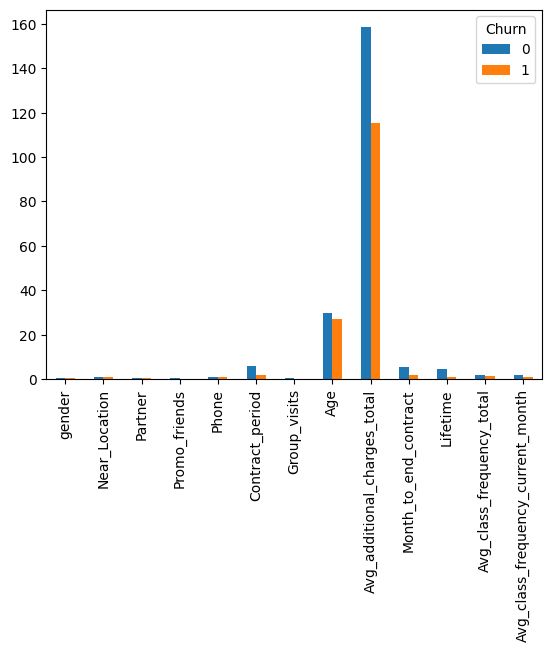

In [8]:
churn_and_nochurn_users.T.plot(kind='bar')                             
plt.show()

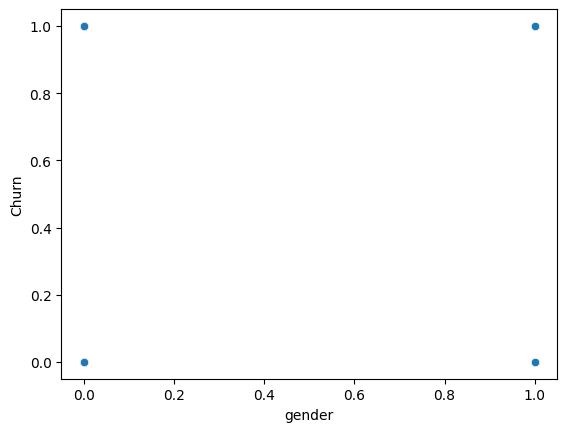

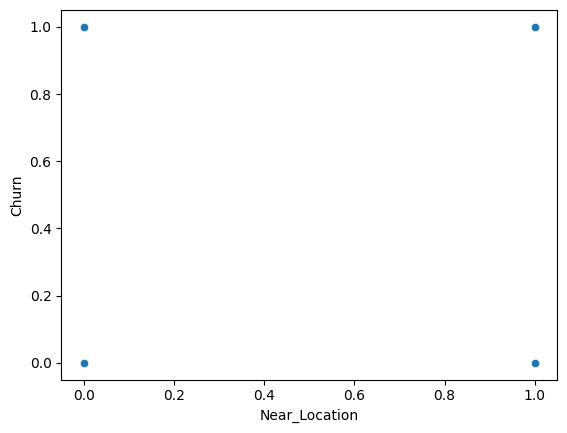

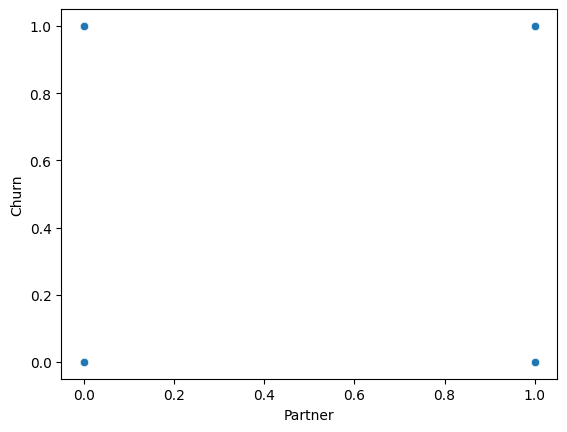

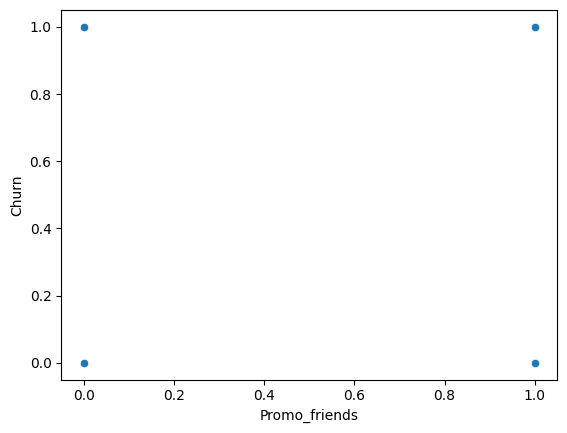

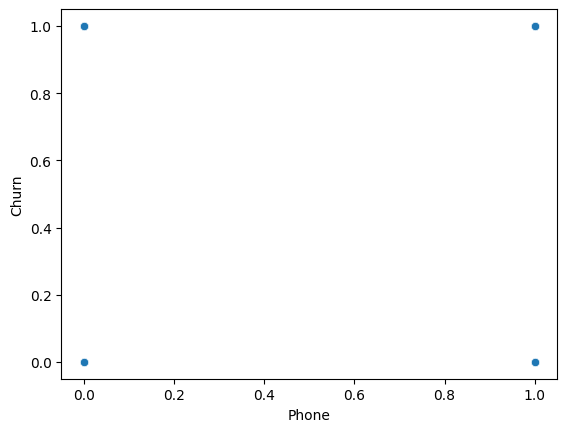

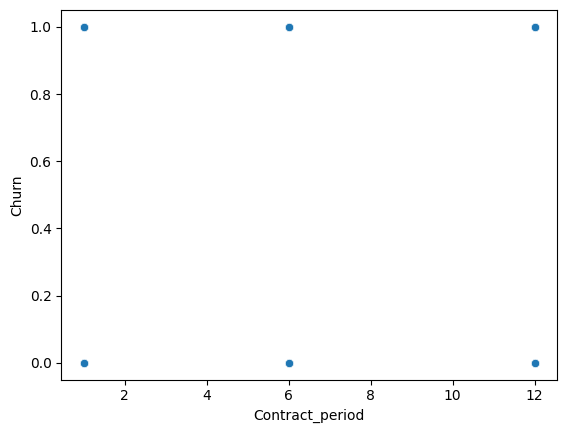

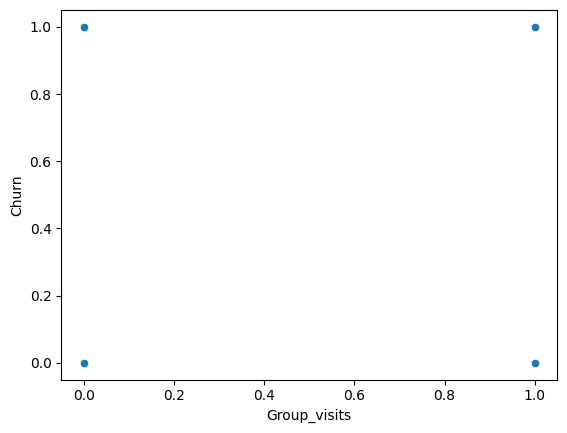

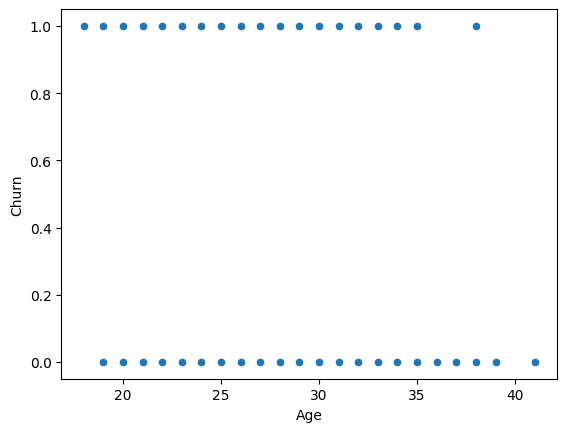

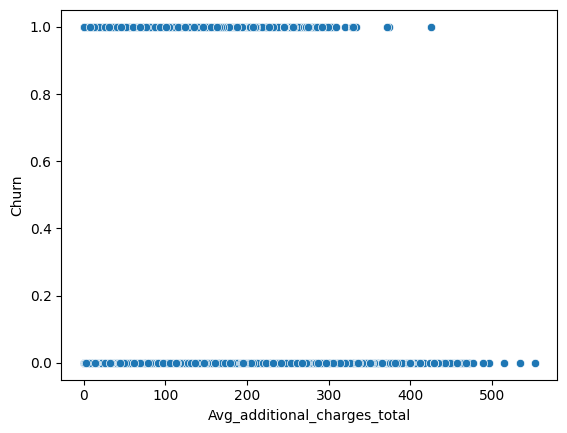

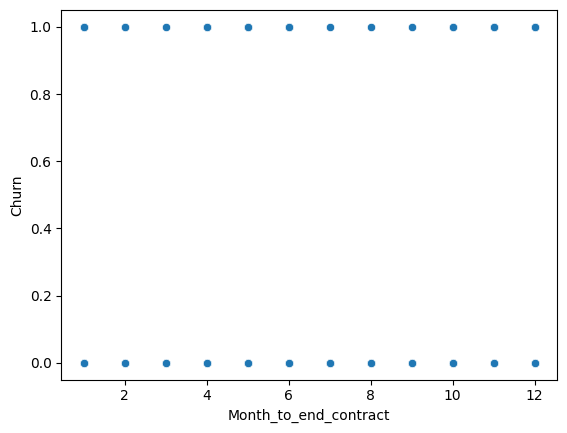

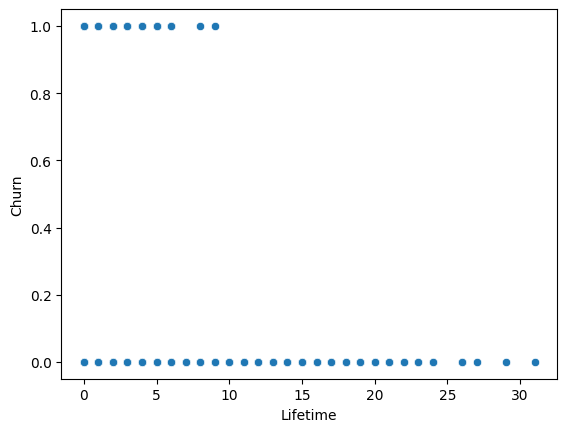

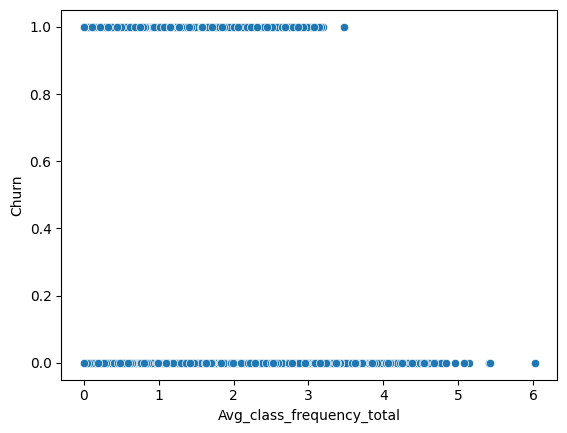

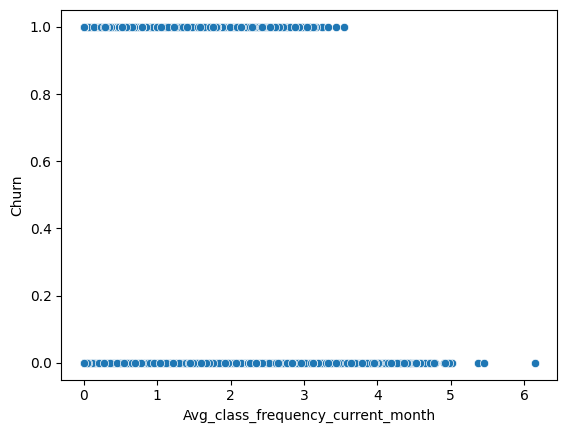

In [9]:
for col in df.drop(['Churn'],axis=1).columns:
    sns.scatterplot(x=df[col],y=df['Churn'])
    plt.show()

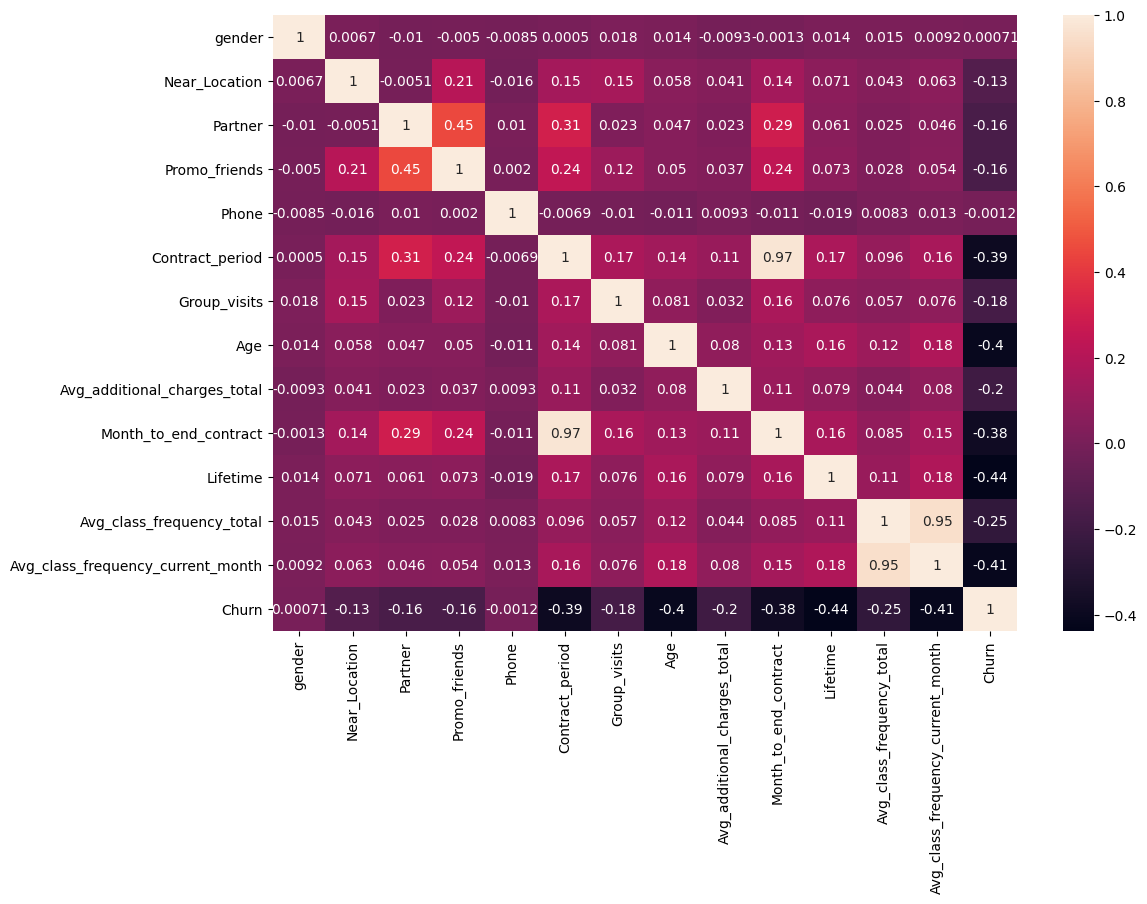

In [10]:
cm = df.corr()
plt.figure(figsize=(12,8)) 
sns.heatmap(cm, annot=True)
plt.show()


-Mediante la agrupacion de por personas que dejan de ir al gimnasio se puede ver que la tendencia de las personas que se quedan en cuanto a la veces que van al gimnasio de forma frecuente, mensual es mayor a las personas que ya no volvieron

-La cantidad de hombres y mujeres que ya sea se queda o se va es casi la misma

-A grandes rasgos las personas que se han quedado han utilizado mas el gimnasio y su servicios 

-Con respectecno a la matriz de correlacion se puede aprecion que hay una fuerte correlacion entre contract_period y month_to_end_contract y Avg_class_frequency_current_month con Avg_class_frequency_total


## Modelos predictivos

In [11]:
X = df.drop('Churn',axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split (X, y , test_size=0.2,random_state=0)

In [12]:
scalar = StandardScaler()
scalar.fit(X_train)

X_train_st = scalar.transform(X_train)
X_test_st = scalar.transform(X_test)


model_logistic = LogisticRegression(random_state=0)
model_logistic.fit(X_train_st, y_train)
model_logistic_predictions = model_logistic.predict(X_test_st)
model_logistic_probabilities = model_logistic.predict_proba(X_test_st)[:,1]

print('Exactitud:{:.2f}'.format(accuracy_score(y_test,model_logistic_predictions)))
print('Presicion:{:.2f}'.format(precision_score(y_test,model_logistic_predictions)))
print('Recall:{:.2f}'.format(recall_score(y_test,model_logistic_predictions)))
print('Roc:{:.2f}'.format(roc_auc_score(y_test,model_logistic_probabilities)))

Exactitud:0.92
Presicion:0.85
Recall:0.83
Roc:0.97


In [13]:
rf_model = RandomForestClassifier(n_estimators=100,random_state=0)

rf_model.fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print('Exactitud:{:.2f}'.format(accuracy_score(y_test,rf_predictions)))
print('Presicion:{:.2f}'.format(precision_score(y_test,rf_predictions)))
print('Recall:{:.2f}'.format(recall_score(y_test,rf_predictions)))
print('Roc:{:.2f}'.format(roc_auc_score(y_test,rf_probabilities)))

Exactitud:0.92
Presicion:0.84
Recall:0.81
Roc:0.97


-Como se puede apreciar los 2 modelos predictivos son confiables ya sea utilizando la exactitud en donde las clases estan equilibradas o presicion y recall en cual no contempla dicho equilibrio

-Con estos valores podemos estar seguro que no nuestras prediciones con respecto a las caracteristicas de lo usuarios que se quedan o se retiran del gimnasio seran confiables

## Clusteres de usuarios

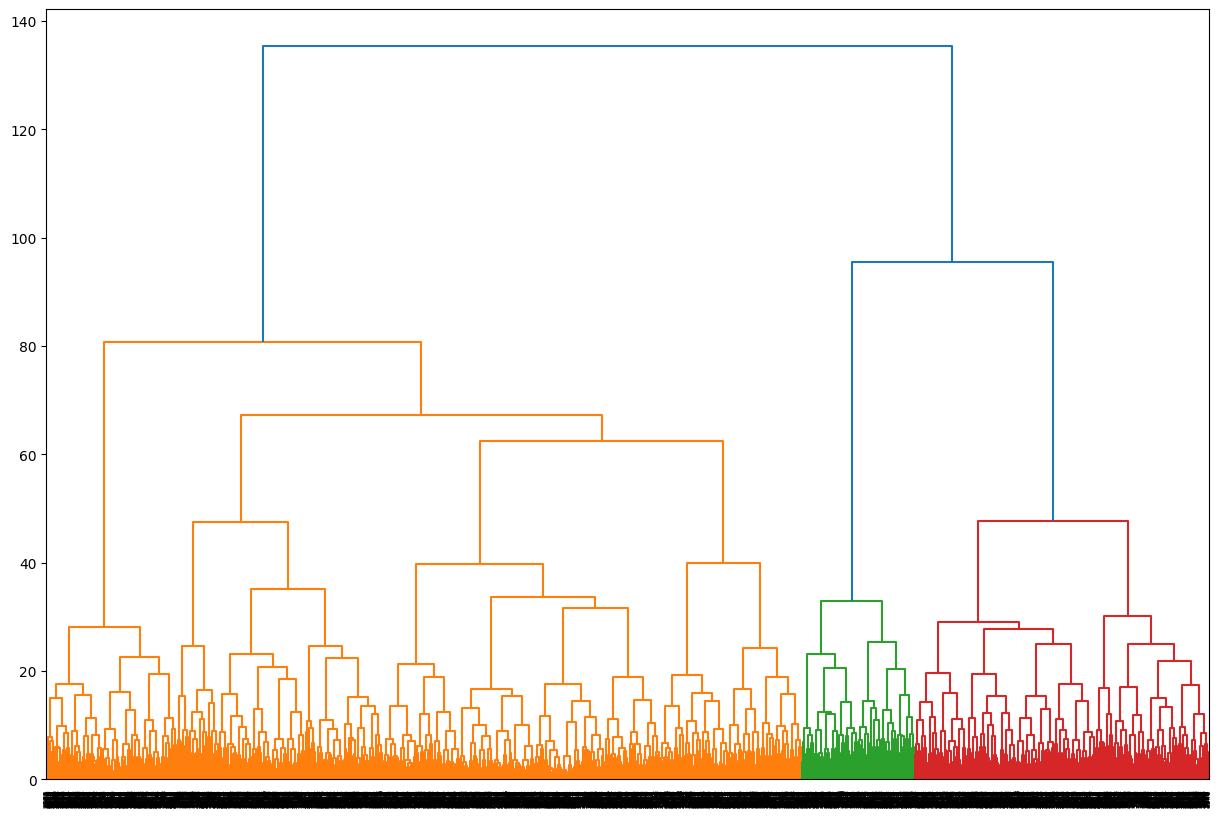

In [20]:
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop(['Churn'],axis=1))

linked = linkage(X_sc, method = "ward")

plt.figure(figsize=(15,10))
dendrogram(linked,orientation="top")
plt.show()


In [21]:
km = KMeans(n_clusters = 5,random_state=0)
labels = km.fit_predict(X_sc)

df['Client_category'] = labels


In [22]:
km_mean = df.groupby(['Client_category']).mean()
print(km_mean)




def show_plot(df,x_name,y_name,cluster_name):
    plt.figure(figsize=(10,10))
    sns.scatterplot(df[x_name], df[y_name],hue=df[cluster_name] )
    plt.show()

                   gender  Near_Location   Partner  Promo_friends     Phone  \
Client_category                                                               
0                0.502970       0.959406  0.783168       0.574257  1.000000   
1                0.485737       1.000000  0.350238       0.240095  1.000000   
2                0.495050       0.000000  0.463366       0.079208  1.000000   
3                0.522078       0.862338  0.470130       0.306494  0.000000   
4                0.559666       0.976134  0.356802       0.230310  0.998807   

                 Contract_period  Group_visits        Age  \
Client_category                                             
0                      10.889109      0.542574  29.982178   
1                       1.948494      0.341521  28.167987   
2                       2.352475      0.215842  28.477228   
3                       4.787013      0.425974  29.301299   
4                       2.669451      0.473747  30.125298   

                 A

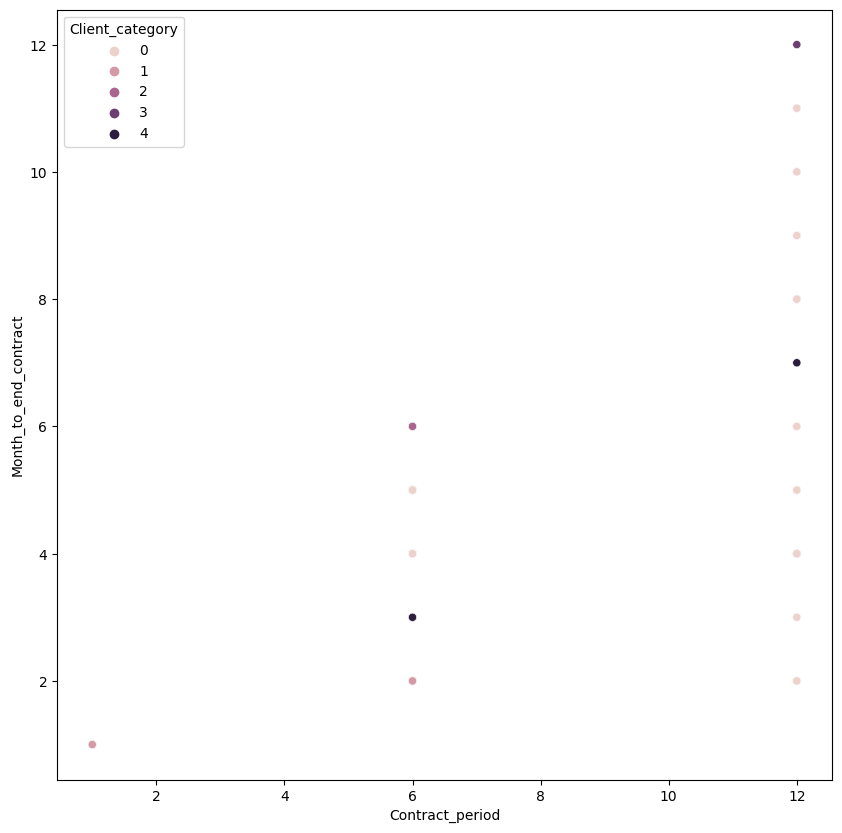

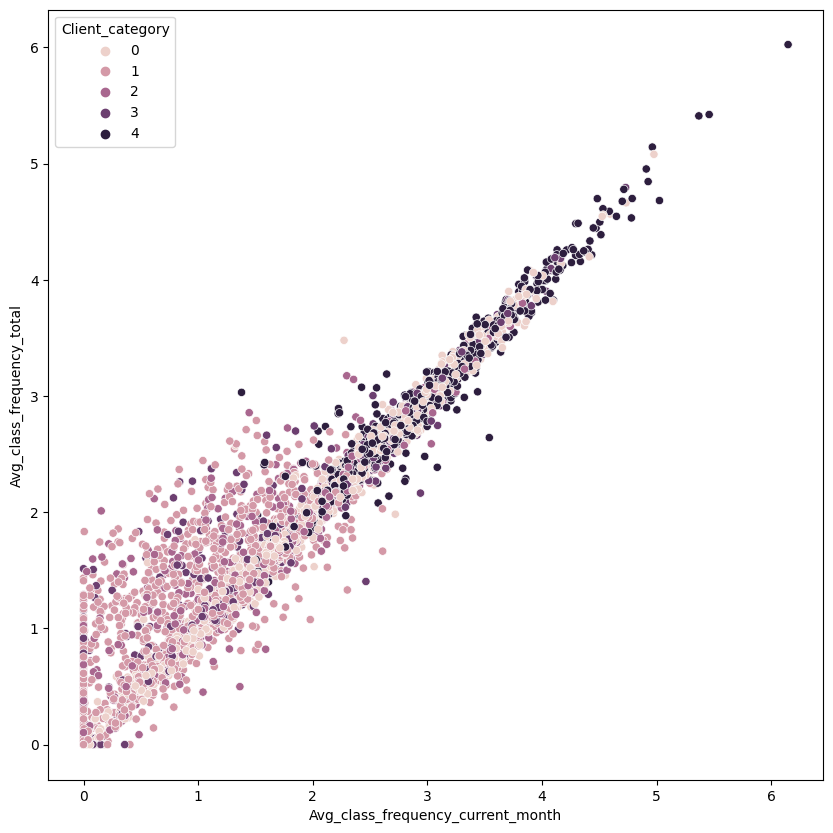

In [23]:
show_plot(df,'Contract_period','Month_to_end_contract','Client_category')
show_plot(df,'Avg_class_frequency_current_month','Avg_class_frequency_total','Client_category')



In [25]:
tasa_cancelacion = df.groupby('Client_category')['Churn'].mean()
print(tasa_cancelacion)

Client_category
0    0.027723
1    0.514263
2    0.443564
3    0.267532
4    0.068019
Name: Churn, dtype: float64


-Mediante el uso de los modelos de clustering podemos ver que se pueden consideran 5 grandes agrupasiones como se ve reflejado
en el dendrograma el cual tiene 5 diferentes colores

-Con el paso anterior podemos definir la cantidad de clusteres para nuestro modelo de clustering k-means que en este caso serian 5

-Los graficos muestran las caracteristicas que tenian una fuerte correlacion como se puede ver las caracteristicas de periodo de contrato con los meses en los el contrato termina se pueden diferenciar claramente en contraste con los la cantidad total de veces que van al gimnasio y la frecuencia mensual en la cual se cuesta diferenciar las categorias (clusteres) siendo estas caracteristas no son buenas para separar los clusteres

-Al agrupar los datos mediante las categorias creadas por el modelo podemos fijarnos primeramente en los grupos tienen un alto promedio de abandono y ver las caracteristicas que contemplan estos grupos



## Conclusiones

-Tomando en consideracion una gran tasa de abandono podemos crear un sistema de recompensas dependiendo de una cantidad en concreto de vences al mes que las personas vayan al gimnasio al completarla dar un descuento por logros o poder asistir a una clase gratis.

-Los grupos que tienen poca participacion en sesiones grupales se podria enviar informacion sobre entrenadores personales o clases que esten de acuerdo a los gustos de estos o bien promocionar una clase gratis al mes para que las personas puedan ver como es.

-Los grupos que gastan menos se podria incentivar implementando diferentes formas de pago, pagos por semana o cantidad sesiones 
por mes o entre mas meses pagodos aplicar una rebaja

-Para los grupos con bajo abandono informar mediante carteles y correos de la implementacion de equipos nuevos y clases avanzadas ya que son los que utilizan mas los servicios mostrar una aptitud para mejorar lo que se tiene permitira que estos tengan una aptitud positiva con el gimnasio.